<a href="https://colab.research.google.com/github/dmachlanski/iads-summer-school-causality-2021/blob/main/labs/Exercise_JOBS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference - Exercise (JOBS)

This is an optional exercise for anyone going quicker throught the labs than anticipated. We leave here very little instructions to let people approach the problem however they want, though it can be tackled in a similar manner as the IHDP one.

This dataset, proposed by [A. Smith and E. Todd (2005)](https://ideas.repec.org/a/eee/econom/v125y2005i1-2p305-353.html), is a combination of the experiment done by [LaLonde (1986)](https://www.jstor.org/stable/1806062) as part of the National Supported Work Program (NSWP) and observational data from the Panel Study of Income Dynamics (PSID) [(Dehejia and Wahba 2002)](https://ideas.repec.org/a/tpr/restat/v84y2002i1p151-161.html). Overall, the data captures people’s basic characteristics, whether they received a job training from NSWP (the treatment), and finally their employment status (the outcome).

JOBS consists of 17 background features (mixture of continuous and binary), a binary treatment, and a binary outcome. It includes 3,212 samples, of which 297/2,915 are treated/control units.

The dataset can be accessed [here](https://github.com/dmachlanski/iads-summer-school-causality-2021/tree/main/labs/data). URLs to training and testing parts of the data:
- https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/jobs_train.npz
- https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/jobs_test.npz

Contrary to previous examples, a different set of evaluation mertics is usually used against JOBS. These are: a) Average Treatment effect on the Treated (ATT), and b) policy risk. They are formally defined as follows.

Given a set of treated subjects $T$ that are part of sample $E$ coming from an experimental study, and a set of control group $C$, define ATT as:

$$ATT = \frac{1}{|T|}\sum \limits_{i \in T}\mathcal{Y}^{(i)} - \frac{1}{|C \cap E|}\sum \limits_{i \in C \cap E}\mathcal{Y}^{(i)}$$

The error on ATT is then defined as the absolute difference between the true and predicted ATT:

$$\epsilon_{ATT} = \left| ATT - \frac{1}{|T|}\sum \limits_{i \in T} (\hat{y}_1^{(i)}-\hat{y}_0^{(i)}) \right|$$

Policy risk can be defined as:

$$\mathcal{R}_{pol} = 1 - (\mathbb{E}\left [ \mathcal{Y}_1|\pi(x)=1 \right ] \mathcal{P}(\pi(x)=1) + \mathbb{E}\left [ \mathcal{Y}_0|\pi(x)=0 \right ] \mathcal{P}(\pi(x)=0)$$

Where $\mathbb{E}[.]$ denotes mathematical expectation and policy $\pi$ becomes $\pi(x)=1$ if $\hat{y}_1 - \hat{y}_0 > 0$; $\pi(x)=0$ otherwise.

The code provided below computes both $\epsilon_{ATT}$ and $\mathcal{R}_{pol}$ given predicted effects. Apart from the background (X), treatment (T) and outcome (Y) covariates, the dataset also contains information whether a unit comes from an experimental study (E), which is required to compute the metrics as well.

In [1]:
def calc_stats(y, t, e, te_pred):
    att = np.mean(y[t > 0]) - np.mean(y[(1 - t + e) > 1])

    att_pred = np.mean(te_pred[(t + e) > 1])
    bias_att = att_pred - att

    policy_value = policy_val(y, t, e, te_pred[e > 0])

    eps_att = np.abs(bias_att)
    r_pol = 1 - policy_value
    return eps_att, r_pol
	
def policy_val(y, t, e, te_pred):
    t_e = t[e > 0]
    y_e = y[e > 0]

    if np.any(np.isnan(te_pred)):
        return np.nan, np.nan

    policy = te_pred > 0.0
    treat_overlap = (policy == t_e) * (t_e > 0)
    control_overlap = (policy == t_e) * (t_e < 1)

    if np.sum(treat_overlap) == 0:
        treat_value = 0
    else:
        treat_value = np.mean(y_e[treat_overlap])

    if np.sum(control_overlap) == 0:
        control_value = 0
    else:
        control_value = np.mean(y_e[control_overlap])

    pit = np.mean(policy)
    policy_value = pit * treat_value + (1 - pit) * control_value

    return policy_value

In [2]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10):
    """
    data: 2-dimensional numpy array
    bins: number of bins in the histograms
    """
    if data.shape[1] > 1:
        sq = math.sqrt(data.shape[1])
        d_ceil = math.ceil(sq)
        d_floor = math.floor(sq)

        if (d_ceil * d_floor) >= data.shape[1]:
            n_rows = d_floor
            n_cols = d_ceil
        else:
            n_rows = n_cols = d_ceil

        _, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
        axs = _trim_axs(axs, data.shape[1])

        for i, ax in enumerate(axs):
            ax.hist(data[:, i], bins=bins)
    else:
        plt.hist(data, bins=bins)
    
    plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math

In [4]:
!wget https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/jobs_train.npz
!wget https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/jobs_test.npz

--2021-07-29 15:51:25--  https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/jobs_train.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2021/main/labs/data/jobs_train.npz [following]
--2021-07-29 15:51:25--  https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2021/main/labs/data/jobs_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402807 (393K) [application/octet-stream]
Saving to: ‘jobs_train.npz’

jobs_train.npz      100%[===================>] 393.37K  --.-KB/s    in 0.04s   

2021-07-

In [5]:
data_train = np.load('jobs_train.npz')
data_test = np.load('jobs_test.npz')

In [6]:
data_train.files

['x', 't', 'y', 'e']

In [7]:
x_train = data_train['x']
t_train = data_train['t']
y_train = data_train['y']
e_train = data_train['e']

In [8]:
x_test, t_test, y_test, e_test = data_test['x'], data_test['t'], data_test['y'], data_test['e']

In [9]:
for f in data_train.files:
  print(f'{f}: {data_train[f].shape}')

x: (2891, 17)
t: (2891, 1)
y: (2891, 1)
e: (2891, 1)


In [10]:
for f in data_test.files:
  print(f'{f}: {data_test[f].shape}')

x: (321, 17)
t: (321, 1)
y: (321, 1)
e: (321, 1)


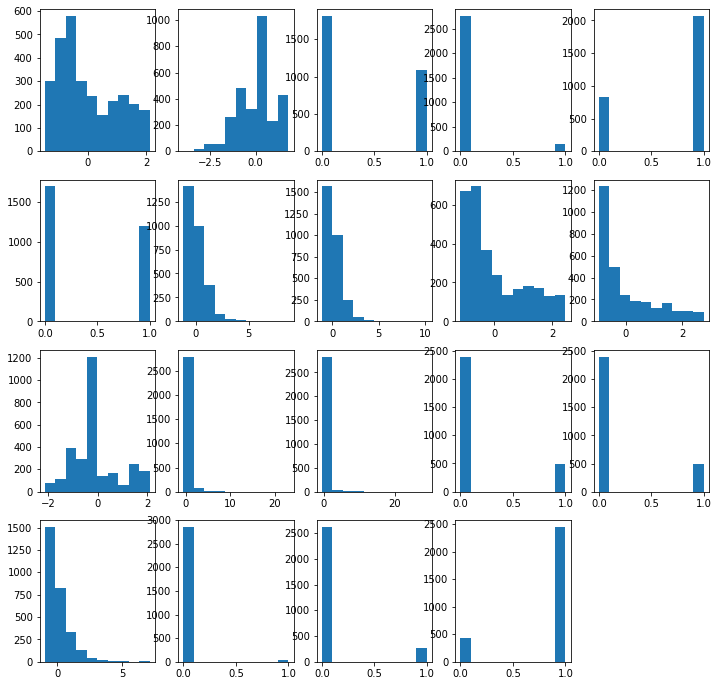

In [11]:
xty_train = np.concatenate([x_train, t_train, y_train], axis=1)

plot_dist(xty_train)

In [12]:
scaler_x = StandardScaler()

x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [14]:
et = ExtraTreesRegressor(1000)

xt_train = np.concatenate([x_train, t_train], axis=1)
et.fit(xt_train, y_train.flatten())

et_y0 = et.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
et_y1 = et.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

et_te = et_y1 - et_y0

In [18]:
et_te.shape

(321,)

In [16]:
#def calc_stats(y, t, e, te_pred):
att_e, r_pol = calc_stats(y_test, t_test, e_test, et_te.reshape(-1, 1))

In [17]:
print(att_e, r_pol)

0.022291271892047125 0.36857142857142855
